# Sketch Recognition using Simple Neural Network (NN)

> - <font size="+1">🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**</font><br/><br/>
> - ▶️ <font size="+1">**Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments)</font>

## Experiment overview

In this experiment we will build a [Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP) model using [Tensorflow](https://www.tensorflow.org/) to recognize handwritten sketches by using a [quick-draw dataset](https://github.com/googlecreativelab/quickdraw-dataset).

A **multilayer perceptron** (MLP) is a class of feedforward artificial neural network. An MLP consists of, at least, three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

![sketch_recognition_mlp.png](../../demos/src/images/sketch_recognition_mlp.png)

## Import dependencies

In [325]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [326]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import pathlib

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [327]:
cache_dir = 'tmp';

In [328]:
# Create cache folder.
!mkdir tmp

mkdir: tmp: File exists


## Load dataset

In [341]:
# List all available datasets to see how the wikipedia dataset is called.
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_natura

In [342]:
DATASET_NAME = 'quickdraw_bitmap'

dataset, dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir=cache_dir,
    with_info=True,
    split=tfds.Split.TRAIN,
)

## Explore dataset

In [343]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='quickdraw_bitmap',
    version=3.0.0,
    description='The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images',
    homepage='https://github.com/googlecreativelab/quickdraw-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=345),
    }),
    total_num_examples=50426266,
    splits={
        'train': 50426266,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/HaE17,
      author    = {David Ha and
                   Douglas Eck},
      title     = {A Neural Representation of Sketch Drawings},
      journal   = {CoRR},
      volume    = {abs/1704.03477},
      year      = {2017},
      url       = {http://arxiv.org/abs/1704.03477

In [344]:
image_shape = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes
num_examples = dataset_info.splits['train'].num_examples

print('num_examples: ', num_examples)
print('image_shape: ', image_shape)
print('num_classes: ', num_classes)

num_examples:  50426266
image_shape:  (28, 28, 1)
num_classes:  345


In [349]:
label_index_to_string = dataset_info.features['label'].int2str

classes = []

for class_index in range(num_classes):
    classes.append(label_index_to_string(class_index))
    
print('classes:\n\n', classes)

classes:

 ['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 

In [350]:
print(dataset)

<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


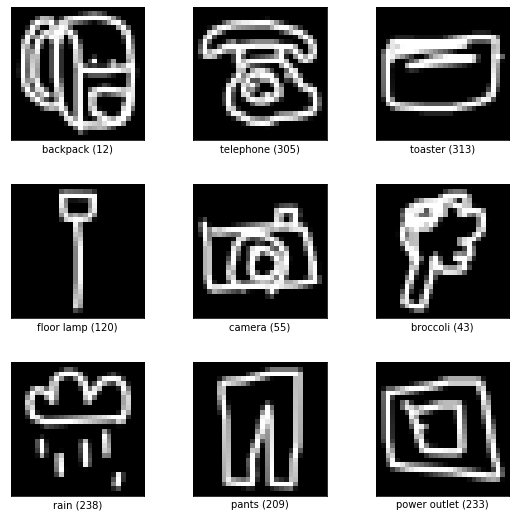

In [347]:
fig = tfds.show_examples(dataset_info, dataset)

In [378]:
def dataset_preview(dataset, image_shape, preview_images_num=100):
    num_cells = math.ceil(math.sqrt(preview_images_num))
    plt.figure(figsize=(17, 17))
    image_size = image_shape[0]
    
    for image_index, example in enumerate(dataset.take(preview_images_num)):
        image = example['image']
        label = example['label']
        
        class_index = label.numpy()
        class_name = label_index_to_string(class_index)
        
        plt.subplot(num_cells, num_cells, image_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            np.reshape(image, (image_size, image_size)),
            cmap=plt.cm.binary
        )
        plt.xlabel('{} ({})'.format(class_name, class_index))
    plt.show()

In [370]:
def dataset_head(ds):
    for example in ds.take(1):
        image = example['image']
        label = example['label']

        class_index = label.numpy()
        class_name = label_index_to_string(class_index)

        print('{} ({})'.format(class_name, class_index), '\n')
        print('Image shape: ', image.shape, '\n')
        print(np.reshape(image.numpy(), (28, 28)), '\n')

In [371]:
dataset_head(dataset)

backpack (12) 

Image shape:  (28, 28, 1) 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3  31  63  95 115
   86  50   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0  75 183 176 152  10  54 182 222 250 255 255 255 255
  255 255 231 151  61   0   0   0   0   0]
 [  0   0   0   0 129 255 216 202 255  98 220 222 157 125  93  60  28   8
   38  82 162 239 254 108   0   0   0   0]
 [  0   0   0  33 250 158   4   0 204 209 255 236 105   0   0   0   0   0
    0   0   0   6 164 254  88   0   0   0]
 [  0   0   0 158 243  30 155 235 211 255 254 185 255  97   0   0   0   0
    0   0   0   0   3 193 229  10   0   0]
 [  0   0  38 251 134 153 251 162 252 245 225   1 180 241   6   0   0   0
    0   0   0   0   0  69 255  62   0   0]
 [  0   0 150 240  26 245 145   0 116 255 149   0  75 255  58   0   0   0
    0   0   0   0   0  29 255  94   0   0]
 [  0   0 209 173  7

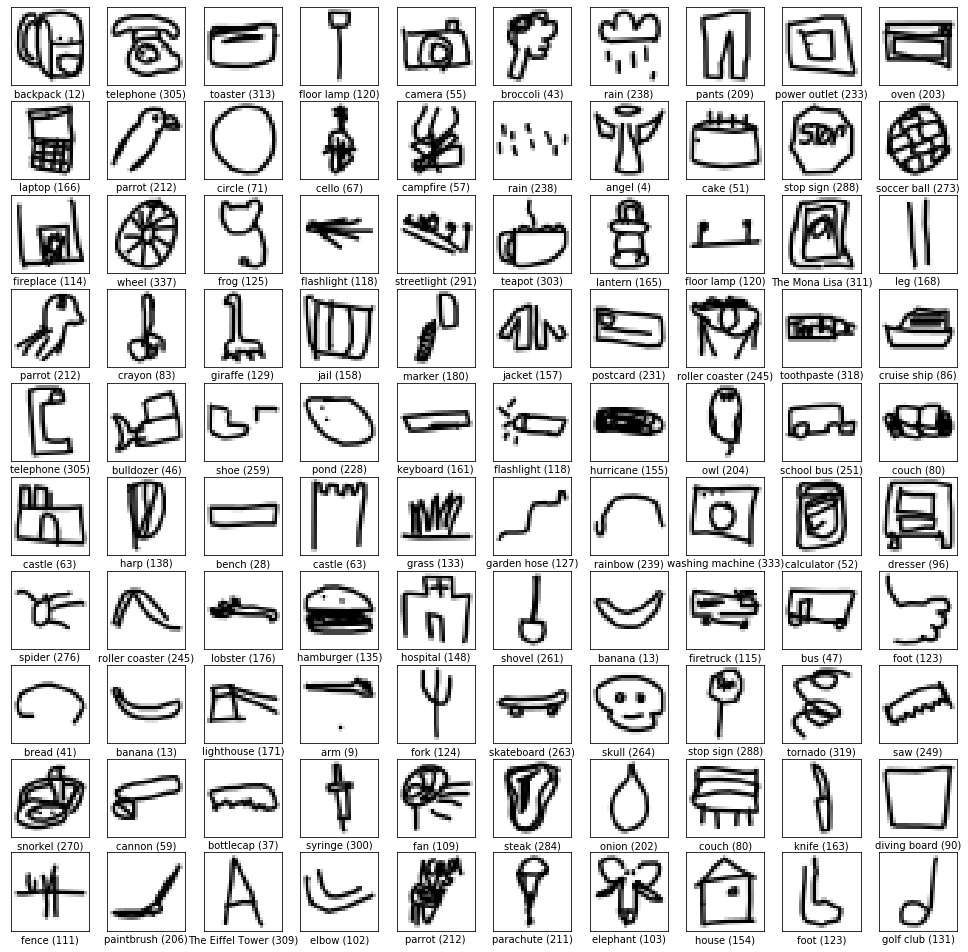

In [379]:
dataset_preview(dataset, image_shape)

## Normalize dataset

In [355]:
def normalize_example(example):
    image = example['image']
    label = example['label']
    
    image = tf.math.divide(image, 255)
    
    return (image, label)

In [356]:
dataset_normalized = dataset.map(normalize_example)

In [362]:
for (image, label) in dataset_normalized.take(1):
    class_index = label.numpy()
    class_name = label_index_to_string(class_index)

    print('{} ({})'.format(class_name, class_index), '\n')
    print('Image shape: ', image.shape, '\n')
    print(np.reshape(image.numpy(), (28, 28)), '\n')

backpack (12) 

Image shape:  (28, 28, 1) 

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.01176471 0.12156863 0.24705882 0.37254903 0.4509804
  0.3372549  0.19607843 0.00784314 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.29411766
  0.7176471  0.6901961  0.59607846 0.03921569 0.21176471 0.7137255
  0.87058824 0.98039216 1.         1.         1.         1.
  1.         1.         0.90588236 0.5921569  0.23921569 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.5058824  1.
  0.84705883 

## Prepare Train/Validation/Test dataset splits

In [359]:
# A quick example of how we're going to split the dataset for train/test/validation subsets.
tmp_ds = tf.data.Dataset.range(10)
print('tmp_ds:', list(tmp_ds.as_numpy_iterator()))

tmp_ds_test = tmp_ds.take(2)
print('tmp_ds_test:', list(tmp_ds_test.as_numpy_iterator()))

tmp_ds_val = tmp_ds.skip(2).take(3)
print('tmp_ds_val:', list(tmp_ds_val.as_numpy_iterator()))

tmp_ds_train = tmp_ds.skip(2 + 3)
print('tmp_ds_train:', list(tmp_ds_train.as_numpy_iterator()))

tmp_ds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tmp_ds_test: [0, 1]
tmp_ds_val: [2, 3, 4]
tmp_ds_train: [5, 6, 7, 8, 9]


In [456]:
# Dataset split
test_dataset_batches = 1
val_dataset_batches = 1

# Dataset batching and shuffling
shuffle_buffer_size = 10000
batch_size = 20000
prefetch_buffer_batches = 10

# Training
epochs = 10
steps_per_epoch = 10

In [457]:
dataset_batched = dataset_normalized \
    .shuffle(
        buffer_size=shuffle_buffer_size,
        reshuffle_each_iteration=True
    ) \
    .batch(batch_size=batch_size)

In [458]:
# TEST dataset.
dataset_test = dataset_batched \
    .take(test_dataset_batches)

# VALIDATION dataset.
dataset_val = dataset_batched \
    .skip(test_dataset_batches) \
    .take(val_dataset_batches)

# TRAIN dataset.
dataset_train = dataset_batched \
    .skip(test_dataset_batches + val_dataset_batches) \
    .prefetch(buffer_size=prefetch_buffer_batches)

In [459]:
for (image_test, label_test) in dataset_test.take(1):
    print('label_test.shape: ', label_test.shape)
    print('image_test.shape: ', image_test.shape)
    
print()    
    
for (image_val, label_val) in dataset_val.take(1):
    print('label_val.shape: ', label_val.shape)
    print('image_val.shape: ', image_val.shape)    
    
print()    
    
for (image_train, label_train) in dataset_train.take(1):
    print('label_train.shape: ', label_train.shape)
    print('image_train.shape: ', image_train.shape)    

label_test.shape:  (20000,)
image_test.shape:  (20000, 28, 28, 1)

label_val.shape:  (20000,)
image_val.shape:  (20000, 28, 28, 1)

label_train.shape:  (20000,)
image_train.shape:  (20000, 28, 28, 1)


## Create model

In [462]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten(
    input_shape=image_shape
))

model.add(tf.keras.layers.Dense(
    units=256,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dense(
    units=256,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dense(
    units=256,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dense(
    units=num_classes,
    activation=tf.keras.activations.softmax
))

In [463]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_50 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_51 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_52 (Dense)             (None, 345)               88665     
Total params: 421,209
Trainable params: 421,209
Non-trainable params: 0
_________________________________________________________________


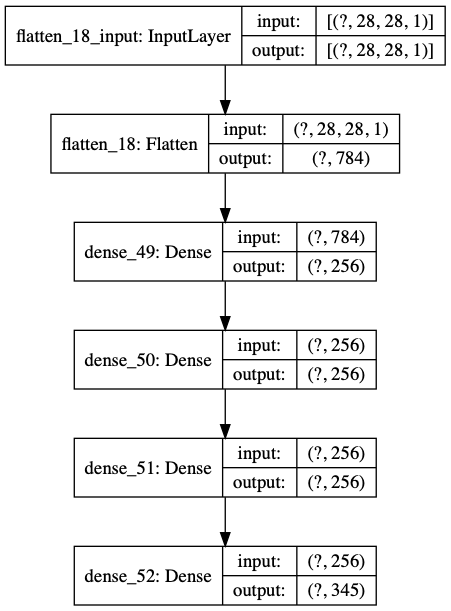

In [464]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [465]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## Train model

In [466]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
)

In [467]:
training_history = model.fit(
    x=dataset_train,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    callbacks=[
        early_stopping_callback
    ]
)

Train for 10 steps
Epoch 1/10
10/10 [==============================] - 51s 5s/step - loss: 5.7515 - accuracy: 0.0119 - val_loss: 5.5370 - val_accuracy: 0.0242
Epoch 2/10
10/10 [==============================] - 44s 4s/step - loss: 5.2783 - accuracy: 0.0426 - val_loss: 4.9255 - val_accuracy: 0.0747
Epoch 3/10
10/10 [==============================] - 48s 5s/step - loss: 4.7431 - accuracy: 0.0964 - val_loss: 4.5313 - val_accuracy: 0.1238
Epoch 4/10
10/10 [==============================] - 60s 6s/step - loss: 4.4178 - accuracy: 0.1388 - val_loss: 4.2923 - val_accuracy: 0.1572
Epoch 5/10
10/10 [==============================] - 53s 5s/step - loss: 4.2098 - accuracy: 0.1672 - val_loss: 4.0894 - val_accuracy: 0.1897
Epoch 6/10
10/10 [==============================] - 49s 5s/step - loss: 4.0467 - accuracy: 0.1909 - val_loss: 3.9656 - val_accuracy: 0.2062
Epoch 7/10
10/10 [==============================] - 54s 5s/step - loss: 3.9334 - accuracy: 0.2066 - val_loss: 3.8504 - val_accuracy: 0.2216
E

In [389]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

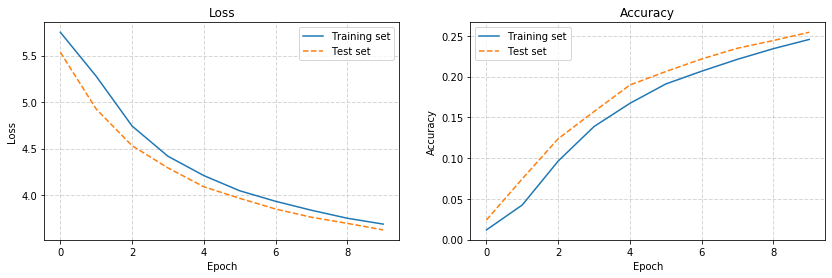

In [468]:
render_training_history(training_history)

## Evaluate model accuracy

### Training set accuracy

In [469]:
%%capture
train_loss, train_accuracy = model.evaluate(dataset_train.take(1))

In [470]:
print('Train loss: ', '{:.2f}'.format(train_loss))
print('Train accuracy: ', '{:.2f}'.format(train_accuracy))

Train loss:  3.64
Train accuracy:  0.25


### Validation set accuracy

In [471]:
%%capture
val_loss, val_accuracy = model.evaluate(dataset_val)

In [472]:
print('Validation loss: ', '{:.2f}'.format(val_loss))
print('Validation accuracy: ', '{:.2f}'.format(val_accuracy))

Validation loss:  3.62
Validation accuracy:  0.26


### Test set accuracy

In [473]:
%%capture
test_loss, test_accuracy = model.evaluate(dataset_test)

In [474]:
print('Test loss: ', '{:.2f}'.format(test_loss))
print('Test accuracy: ', '{:.2f}'.format(test_accuracy))

Test loss:  3.65
Test accuracy:  0.25


## Save the model

We will save the entire model to a `HDF5` file. The `.h5` extension of the file indicates that the model should be saved in Keras format as HDF5 file. To use this model on the front-end we will convert it (later in this notebook) to Javascript understandable format (`tfjs_layers_model` with .json and .bin files) using [tensorflowjs_converter](https://www.tensorflow.org/js/tutorials/conversion/import_saved_model) as it is specified in the [main README](https://github.com/trekhleb/machine-learning-experiments).

In [439]:
model_name = 'sketch_recognition_mlp.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/sketch_recognition_mlp/sketch_recognition_mlp.h5 \
  ./demos/public/models/sketch_recognition_mlp
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.